In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from pprint import pprint
from collections import defaultdict
from pathlib import Path
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source, slice_d
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg
from knowledge_tracing.trainer import Trainer

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
projectdir = Path('/code')
assert projectdir.exists()

In [11]:
config_name = '20_0218_edm2020_asmt0910'
config_dicts = []
for c in sorted([load_rep_cfg(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['pre_dummy_epoch_size']):
    if len(get_best_model_paths(projectdir, c)) == 0:
        raise (c['exp_name'])
    c['load_model'] = get_best_model_paths(projectdir, c)[-1]
    config_dicts.append(c)
    
# config_dicts = [c for c in config_dicts
#  if c['pre_dummy_epoch_size'] in {0, 10, 150}]

In [12]:
def get_simu_res(config_dic):
    config = Config(config_dic, projectdir)
    config.batch_size = 1
    trainer = Trainer(config)
    trainer.init_model()
    trainer.load_model()
#     trainer.evaluate_model()

    seq_size = config.sequence_size
    simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]
#     simu = [[1]*i + [0]*(seq_size - i) for i in range(seq_size+1)]
#     simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size)] + [[1]*i + [0]*(seq_size - i) for i in range(seq_size)]

    simu_res = dict()
    for v in range(config.n_skills):
        xs = []
        preds = []
        for s in simu:
            res = trainer.model.loss_batch(
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.BoolTensor([True]*seq_size).unsqueeze(0),)
            preds.append(res['pred_prob'][-1].item())
            xs.append(sum(s))
        simu_res[v] = (xs, preds)
    return simu_res


simures_list = []
for config_dic in config_dicts:
    simu_res = get_simu_res(config_dic)
    simures_list.append(simu_res)
    

base_res = None
descres_list = []
for simu_res in simures_list:
    if base_res is None:
        base_res = {k:v for k, v in sorted(simu_res.items(), key=lambda it: it[1][1][0] - it[1][1][-1])}
    else:
        desc_res = {k:simu_res[k] for k in base_res.keys()}
        descres_list.append(desc_res)

INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| The model has 514,424 trainable parameters
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| The model has 514,424 trainable parameters
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| The model has 514,424 trainable parameters
INFO : 1348 : 19:50 : ksdkt/pre_dummy_epoch_size0.auto 	| The model has 514,424 trainable paramet

In [13]:
# simple simu
seq_size = 20
simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]
simu

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [14]:
# bi simu
seq_size = 20
simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size)] + [[1]*i + [0]*(seq_size - i) for i in range(seq_size)]
simu

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

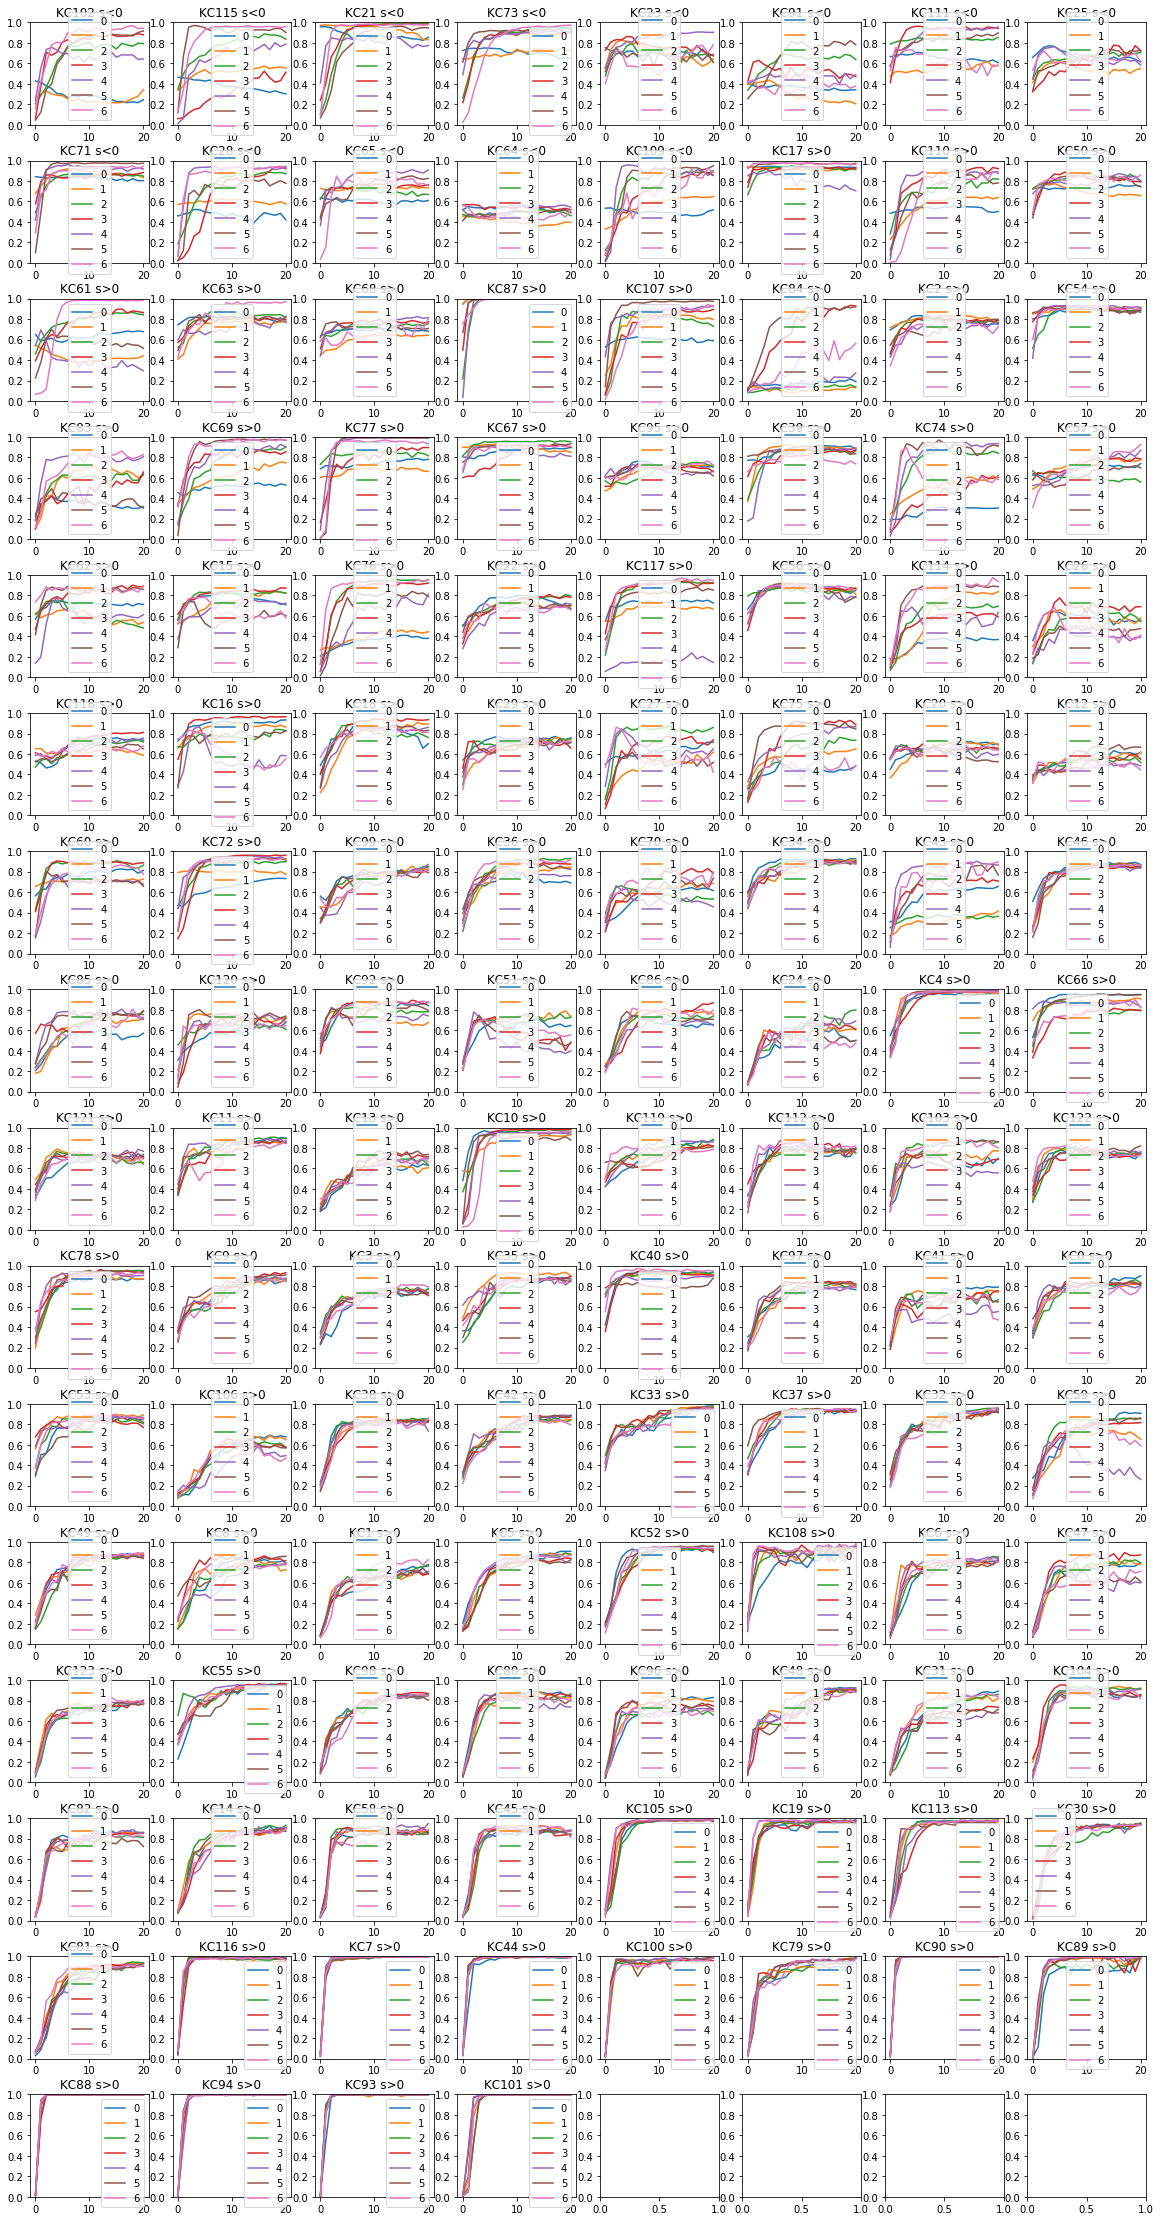

In [15]:
h, w = (124+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]<sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='0', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
ax.legend()
plt.show()

In [20]:
def get_simu_res_ndcg(config_dic, ndcg=ndcg_score):
    config = Config(config_dic, projectdir)
    config.batch_size = 1
    trainer = Trainer(config)
    trainer.init_model()
    trainer.load_model()

    seq_size = config.sequence_size
#     simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]
    simu = [[1]*i + [0]*(seq_size - i) for i in range(seq_size+1)]
#     simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size)] + [[1]*i + [0]*(seq_size - i) for i in range(seq_size)]

    simu_res = dict()
    simu_ndcg = []
    for v in range(config.n_skills):
        xs = []
        preds = []
        for s in simu:
            res = trainer.model.loss_batch(
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.BoolTensor([True]*seq_size).unsqueeze(0),)
            preds.append(res['pred_prob'][-1].item())
            xs.append(sum(s))
        simu_res[v] = (xs, preds)
        simu_ndcg.append(ndcg(np.asarray([xs]), np.asarray([preds])))
    return simu_ndcg

In [28]:
res = {}
for config_dic in config_dicts:
    if config_dic['pre_dummy_epoch_size'] not in {0, 10}:
        continue
    simu_ndcg_list = get_simu_res_ndcg(config_dic)
#     name = config_dic['exp_name']
    name = 'DKT pre {}'.format(config_dic['pre_dummy_epoch_size'])
    res[name] = simu_ndcg_list

INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:46 : ksdkt/pre_dummy_epoch

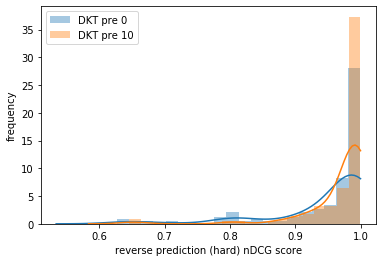

In [31]:
for name, s in res.items(): 
    sns.distplot(s, bins=20, label=name, kde_kws={'clip': (0.0, 1.0)})
plt.xlabel('reverse prediction (hard) nDCG score')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [19]:
res = {}
for config_dic in config_dicts:
    simu_ndcg_list = get_simu_res_ndcg(config_dic)
    s = pd.Series(simu_ndcg_list)
    res[config_dic['exp_name']] = s

for name, s in res.items():
    print(f'name: {s.mean()} {s.std()}')

INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| PyTorch: 1.3.0
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:26 : ksdkt/pre_dummy_epoch_size0.auto 	| Using Device: cuda
INFO : 1348 : 20:26 : ksdkt

name: 0.9454485671802546 0.08459334255364839
name: 0.9549549050184091 0.08182932534382228
name: 0.9717294104039514 0.052219225651811474
name: 0.9699291570562051 0.053380750999893305
name: 0.9646727686956064 0.042749367423833916
name: 0.9737493067875647 0.039395427236744926
name: 0.9651074851808593 0.06005180593269344


# Learning curve for `20_0220_edm2020_asmt15`

In [17]:
config_name = '20_0220_edm2020_asmt15'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['sequence_size'])
[r['config']['exp_name'] for r in report_dicts]

['sequence_size15padTrue.auto',
 'sequence_size15padFalse.auto',
 'sequence_size20padFalse.auto',
 'sequence_size20padTrue.auto',
 'sequence_size30padFalse.auto',
 'sequence_size30padTrue.auto',
 'sequence_size40padFalse.auto',
 'sequence_size40padTrue.auto',
 'sequence_size50padFalse.auto',
 'sequence_size50padTrue.auto',
 'sequence_size100padFalse.auto',
 'sequence_size100padTrue.auto']

In [22]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

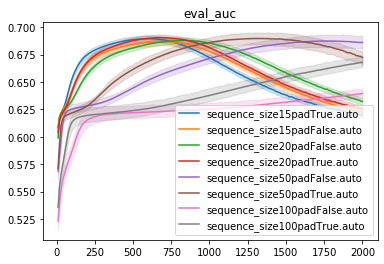

In [23]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

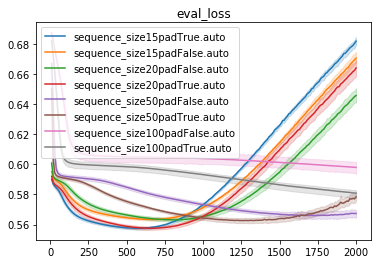

In [24]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0220_edm2020_asmt15`

In [41]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [42]:
for r in report_dicts:
    summarize_test_res(r)

sequence_size15padTrue.auto:	Best epoch at  600.0±14.1 	AUC: 69.0746±0.1098

sequence_size15padFalse.auto:	Best epoch at  694.0±8.9  	AUC: 68.7875±0.1249

sequence_size20padFalse.auto:	Best epoch at  836.0±31.3 	AUC: 68.8453±0.1469

sequence_size20padTrue.auto:	Best epoch at  686.0±33.6 	AUC: 69.1648±0.1259

sequence_size50padFalse.auto:	Best epoch at 1776.0±68.0 	AUC: 68.5738±0.2209

sequence_size50padTrue.auto:	Best epoch at 1340.0±100.2	AUC: 68.8355±0.1611

sequence_size100padFalse.auto:	Best epoch at 2000.0±0.0  	AUC: 64.0471±0.3785

sequence_size100padTrue.auto:	Best epoch at 2000.0±0.0  	AUC: 66.3083±0.2184

